<a href="https://colab.research.google.com/github/juliosdutra/ModelagemPPEQ1019/blob/main/meat_composition.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

### Exemplo de aplicação: análise da composição de carnes

O conjunto de dados está relacionado com análises de composição de amostras de carne. O objetivo é fazer uso registros de um "Tecator Infratec Food and Feed Analyzer", na faixa de comprimento de onda 850 - 1050 nm pelo princípio de transmissão de infravermelho próximo, para predição do conteúdo de água, gordura e proteína da carne. Então, basicamente, a ideia da modelagem é evitar o trabalho de medição demorado e depender apenas de colocar a amostra de carne no scanner e obter o conteúdo estimado de gordura, água e proteína.

Neste conjunto, há 215 amostras compostas de:
* 100 canais de espectro de absorbância (*features*); e
* 3 variáveis dependentes (*targets*): as porcentagens de água, gordura e proteína.

O objetivo da Regressão Linear é modelar a relação de dependência entre as variáveis dependentes (*targets*) e múltiplas variáveis independentes (*features*).

Para mais detalhes, veja uma descrição disponível em:
https://search.r-project.org/CRAN/refmans/modeldata/html/meats.html

In [ ]:
# Importar as bibliotecas básicas
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import warnings

In [ ]:
# Importar os dados
# URL direta para o arquivo XLS no GitHub
url = "https://raw.githubusercontent.com/juliosdutra/ModelagemPPEQ1019/refs/heads/main/meats.csv"
df = pd.read_csv(url)
df.head()

,x_001,x_002,x_003,x_004,x_005,x_006,x_007,x_008,x_009,x_010,...,x_094,x_095,x_096,x_097,x_098,x_099,x_100,water,fat,protein
0,2.61776,2.61814,2.61859,2.61912,2.61981,2.62071,2.62186,2.62334,2.62511,2.62722,...,2.94013,2.91978,2.89966,2.87964,2.85960,2.83940,2.81920,60.5,22.5,16.7
1,2.83454,2.83871,2.84283,2.84705,2.85138,2.85587,2.86060,2.86566,2.87093,2.87661,...,3.26655,3.25369,3.24045,3.22659,3.21181,3.19600,3.17942,46.0,40.1,13.5
2,2.58284,2.58458,2.58629,2.58808,2.58996,2.59192,2.59401,2.59627,2.59873,2.60131,...,2.65112,2.63262,2.61461,2.59718,2.58034,2.56404,2.54816,71.0,8.4,20.5
3,2.82286,2.82460,2.82630,2.82814,2.83001,2.83192,2.83392,2.83606,2.83842,2.84097,...,2.92576,2.90251,2.87988,2.85794,2.83672,2.81617,2.79622,72.8,5.9,20.7
4,2.78813,2.78989,2.79167,2.79350,2.79538,2.79746,2.79984,2.80254,2.80553,2.80890,...,3.25831,3.23784,3.21765,3.19766,3.17770,3.15770,3.13753,58.3,25.5,15.5


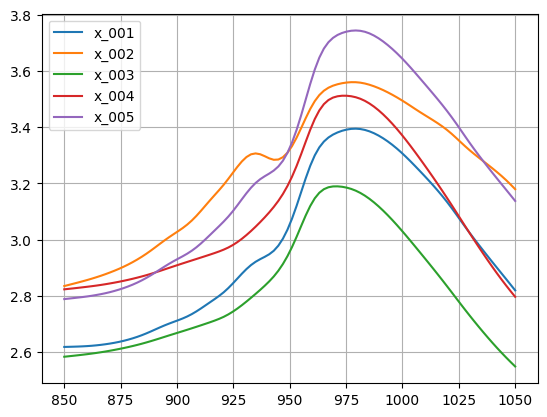

In [ ]:
# Divisão dos dados entre variáveis independentes (feature) e dependentes (target)
target = ['water', 'fat', 'protein']
X = df.drop(target,axis=1).values  # Variável independente
y = df[target].values # Variável dependente

# Visualização gráfica
n, m = X.shape
w = np.linspace(850,1050,m)

for k in range(5): # Plot das 5 primeiras amostras
    plt.plot(w, X[k,:], label = df.columns[k])
plt.legend()
plt.grid();

# Normalização/Padronização dos Espectros
Os espectros de absorbância podem ter diferentes escalas, então faz sentido aplicar uma normalização ou padronização:

**Padronização (Z-score normalization)**
Garante que os dados tenham média 0 e desvio padrão 1.

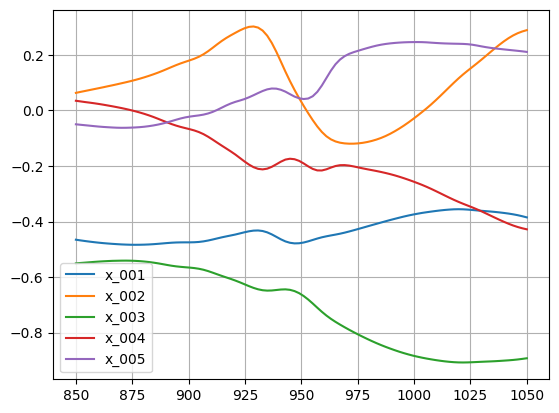

In [ ]:
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)  # Normalizando apenas os espectros (não as variáveis-alvo)


for k in range(5): # Plot das 5 primeiras amostras
    plt.plot(w, X_scaled[k,:], label = df.columns[k])
plt.legend()
plt.grid();

**Normalização Min-Max**
Traz os valores para um intervalo de [0,1], útil para redes neurais e regressões regulares.

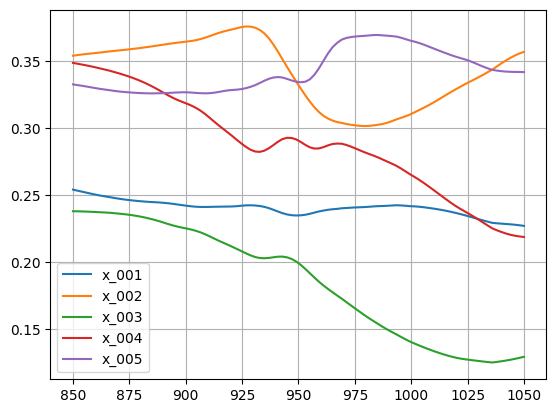

In [ ]:
from sklearn.preprocessing import MinMaxScaler

scaler = MinMaxScaler()
X_scaled = scaler.fit_transform(X)

for k in range(5): # Plot das 5 primeiras amostras
    plt.plot(w, X_scaled[k,:], label = df.columns[k])
plt.legend()
plt.grid();

# Transformações Espectrais para Melhorar o Modelo

Muitos métodos quimiométricos usam pré-processamento espectral para remover ruído e melhorar a modelagem. Algumas opções incluem:

**Derivadas de Savitzky-Golay**
Ajuda a remover ruído e melhorar a resolução espectral.

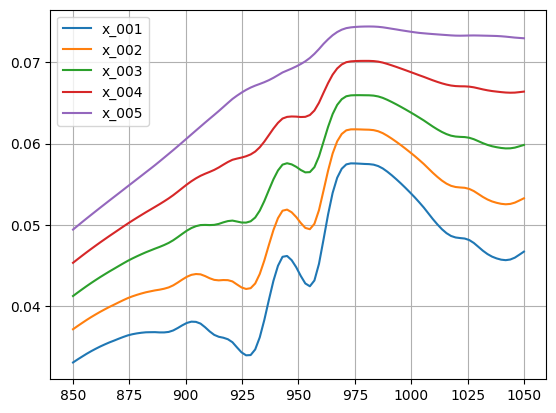

In [ ]:
from scipy.signal import savgol_filter

X_smooth = savgol_filter(X, window_length=11, polyorder=2, deriv=1, axis=0)  # Primeira derivada

for k in range(5): # Plot das 5 primeiras amostras
    plt.plot(w, X_smooth[k,:], label = df.columns[k])
plt.legend()
plt.grid();

**Normalização por Padrão Interno (SNV - Standard Normal Variate)**
Remove variações sistemáticas devido à dispersão da luz.

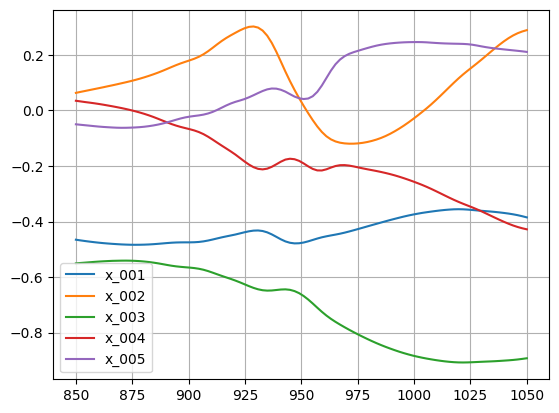

In [ ]:
def snv(input_data):
    return (input_data - np.mean(input_data, axis=0)) / np.std(input_data, axis=0)

X_snv = snv(X)

for k in range(5): # Plot das 5 primeiras amostras
    plt.plot(w, X_snv[k,:], label = df.columns[k])
plt.legend()
plt.grid();


**Transformação de Correlação de Detecção (MSC - Multiplicative Scatter Correction)**
Reduz variações entre amostras devido a efeitos físicos.

In [ ]:
def msc(input_data):
    mean_spectrum = np.mean(input_data, axis=0)
    corrected = np.array([np.polyfit(mean_spectrum, spectrum, 1)[0] for spectrum in input_data])
    return corrected

X_msc = msc(X)

# Redução de Dimensionalidade (PCA ou PLSR)
Como temos 100 variáveis preditoras, pode ser interessante reduzir a dimensionalidade:

**(a) PCA (Análise de Componentes Principais)**
Reduz os espectros para componentes principais que explicam a maior parte da variação nos dados.

In [ ]:
from sklearn.decomposition import PCA

pca = PCA(n_components=2)  # Reduzindo para 10 componentes principais
X_pca = pca.fit_transform(X_scaled)

print(f"Variância explicada acumulada: {sum(pca.explained_variance_ratio_):.2f}")


Variância explicada acumulada: 1.00


**PLSR (Partial Least Squares Regression)**
Método mais adequado para espectroscopia, pois otimiza a relação entre preditores e alvos.

In [ ]:
from sklearn.cross_decomposition import PLSRegression

pls = PLSRegression(n_components=10)
pls.fit(X_scaled, df.iloc[:, -3:])  # Treinando o modelo para prever gordura, água e proteína


PLSRegression(n_components=10)

# CÓDIGO COMPLETO

📌 O que esse código faz?

1️⃣ Baixa os dados do GitHub

2️⃣ Pré-processa os espectros (Z-score → SNV → Savitzky-Golay)

3️⃣ Divide os dados em treino e teste (80% treino, 20% teste)

4️⃣ Treina um modelo PLSR (com 10 componentes)

5️⃣ Faz previsões e avalia o modelo (RMSE e R²)

6️⃣ Gera gráficos predição vs valor real para cada variável alvo


💡 Dicas para melhorar:

🔹 Ajuste o número de componentes PLS (n_components) para otimizar o desempenho

🔹 Teste diferentes parâmetros de suavização (Savitzky-Golay)

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.cross_decomposition import PLSRegression
from sklearn.metrics import mean_squared_error, r2_score
from scipy.signal import savgol_filter

In [ ]:
# 🔹 1️⃣ Importar os dados
url = "https://raw.githubusercontent.com/juliosdutra/ModelagemPPEQ1019/main/meats.csv"
df = pd.read_csv(url)

# Separar as features (espectros) e os targets (composição química)
X = df.iloc[:, :-3].values  # Espectros (100 colunas)
y = df.iloc[:, -3:].values  # Teores de água, gordura e proteína

In [ ]:
# 🔹 2️⃣ Pré-processamento

## Padronização (Z-score)
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

## SNV (Standard Normal Variate)
def snv(input_data):
    return (input_data - np.mean(input_data, axis=1, keepdims=True)) / np.std(input_data, axis=1, keepdims=True)

X_snv = snv(X_scaled)

## Suavização e derivadas (Savitzky-Golay)
X_smooth = savgol_filter(X_snv, window_length=11, polyorder=2, deriv=1, axis=1)

In [ ]:
# 🔹 3️⃣ Divisão Treino/Teste
X_train, X_test, y_train, y_test = train_test_split(X_smooth, y, test_size=0.2, random_state=42)

# 🔹 4️⃣ Treinamento do modelo PLSR
pls = PLSRegression(n_components=10)  # Ajuste o número de componentes
pls.fit(X_train, y_train)

# 🔹 5️⃣ Predição e Validação
y_pred = pls.predict(X_test)

In [ ]:
## Cálculo das métricas
rmse = np.sqrt(mean_squared_error(y_test, y_pred))
r2 = r2_score(y_test, y_pred)

print(f"RMSE: {rmse:.4f}")
print(f"R²: {r2:.4f}")

RMSE: 4.1069
R²: 0.7842


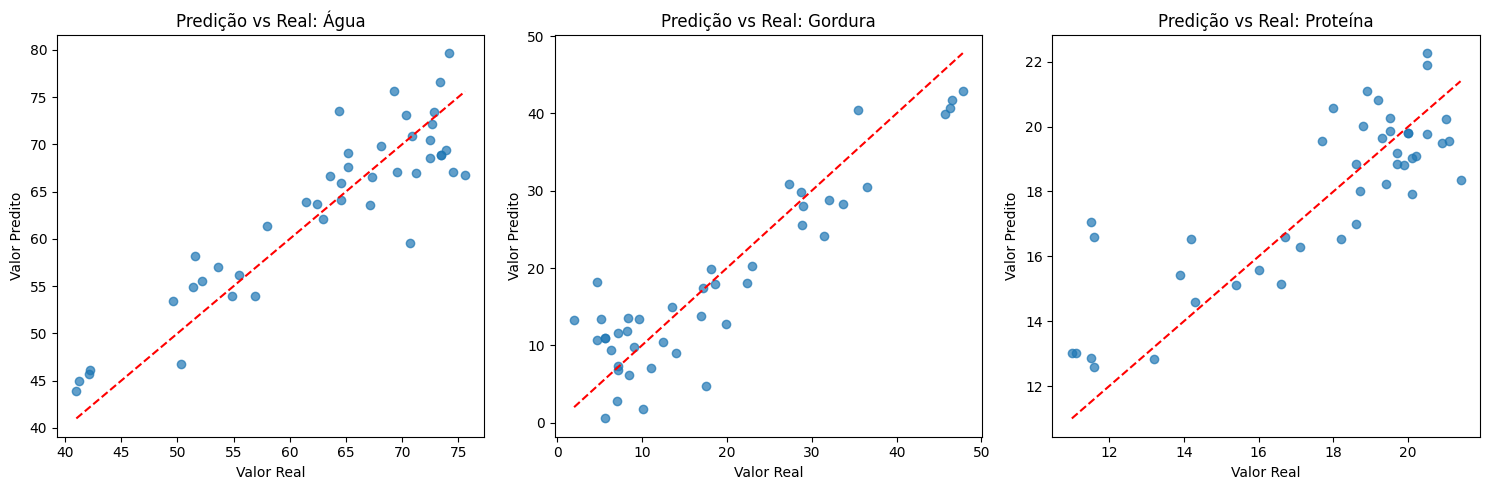

In [ ]:
# 🔹 6️⃣ Visualização dos Resultados
fig, axes = plt.subplots(1, 3, figsize=(15, 5))
targets = ["Água", "Gordura", "Proteína"]

for i in range(3):
    axes[i].scatter(y_test[:, i], y_pred[:, i], alpha=0.7)
    axes[i].plot([min(y_test[:, i]), max(y_test[:, i])], [min(y_test[:, i]), max(y_test[:, i])], 'r--')
    axes[i].set_title(f"Predição vs Real: {targets[i]}")
    axes[i].set_xlabel("Valor Real")
    axes[i].set_ylabel("Valor Predito")

plt.tight_layout()
plt.show()
